In [93]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from hmmlearn import hmm
from scipy.signal import savgol_filter
from joblib import dump
from sklearn.model_selection import KFold

%matplotlib inline

### Load Training Data

In [94]:
dir_train = "./2019Proj2_train/"
filenames = np.array(os.listdir(dir_train))
gestures = ["beat3", "beat4", "circle", "eight", "inf", "wave"]

train_lists = {}
for g in gestures:
    train_lists[g] = np.array([t for t in filenames if t.startswith(g)])
    print(g, train_lists[g])

train_X = {}
for g in gestures:
    train_X[g] = []
    for fname in train_lists[g]:
        train_X[g].append(np.genfromtxt(os.path.join(dir_train, fname), delimiter='\t'))
        if len(train_X[g][-1]) > 1000:
            train_X[g][-1] = train_X[g][-1][300:-300]
        else:
            train_X[g][-1] = train_X[g][-1][300:]
        print(fname, train_X[g][-1].shape)
    train_X[g] = np.array(train_X[g])

beat3 ['beat3_01.txt' 'beat3_02.txt' 'beat3_03.txt' 'beat3_06.txt'
 'beat3_08.txt' 'beat3_31.txt']
beat4 ['beat4_01.txt' 'beat4_03.txt' 'beat4_05.txt' 'beat4_08.txt'
 'beat4_09.txt' 'beat4_31.txt']
circle ['circle12.txt' 'circle13.txt' 'circle14.txt' 'circle17.txt'
 'circle18.txt' 'circle31.txt']
eight ['eight01.txt' 'eight02.txt' 'eight04.txt' 'eight07.txt' 'eight08.txt'
 'eight31.txt']
inf ['inf11.txt' 'inf112.txt' 'inf13.txt' 'inf16.txt' 'inf18.txt' 'inf31.txt']
wave ['wave01.txt' 'wave02.txt' 'wave03.txt' 'wave05.txt' 'wave07.txt'
 'wave31.txt']
beat3_01.txt (1620, 7)
beat3_02.txt (2008, 7)
beat3_03.txt (2043, 7)
beat3_06.txt (2265, 7)
beat3_08.txt (2495, 7)
beat3_31.txt (449, 7)
beat4_01.txt (2417, 7)
beat4_03.txt (2488, 7)
beat4_05.txt (1707, 7)
beat4_08.txt (2013, 7)
beat4_09.txt (2409, 7)
beat4_31.txt (545, 7)
circle12.txt (1344, 7)
circle13.txt (1754, 7)
circle14.txt (1533, 7)
circle17.txt (1695, 7)
circle18.txt (1301, 7)
circle31.txt (328, 7)
eight01.txt (1791, 7)
eight02.txt

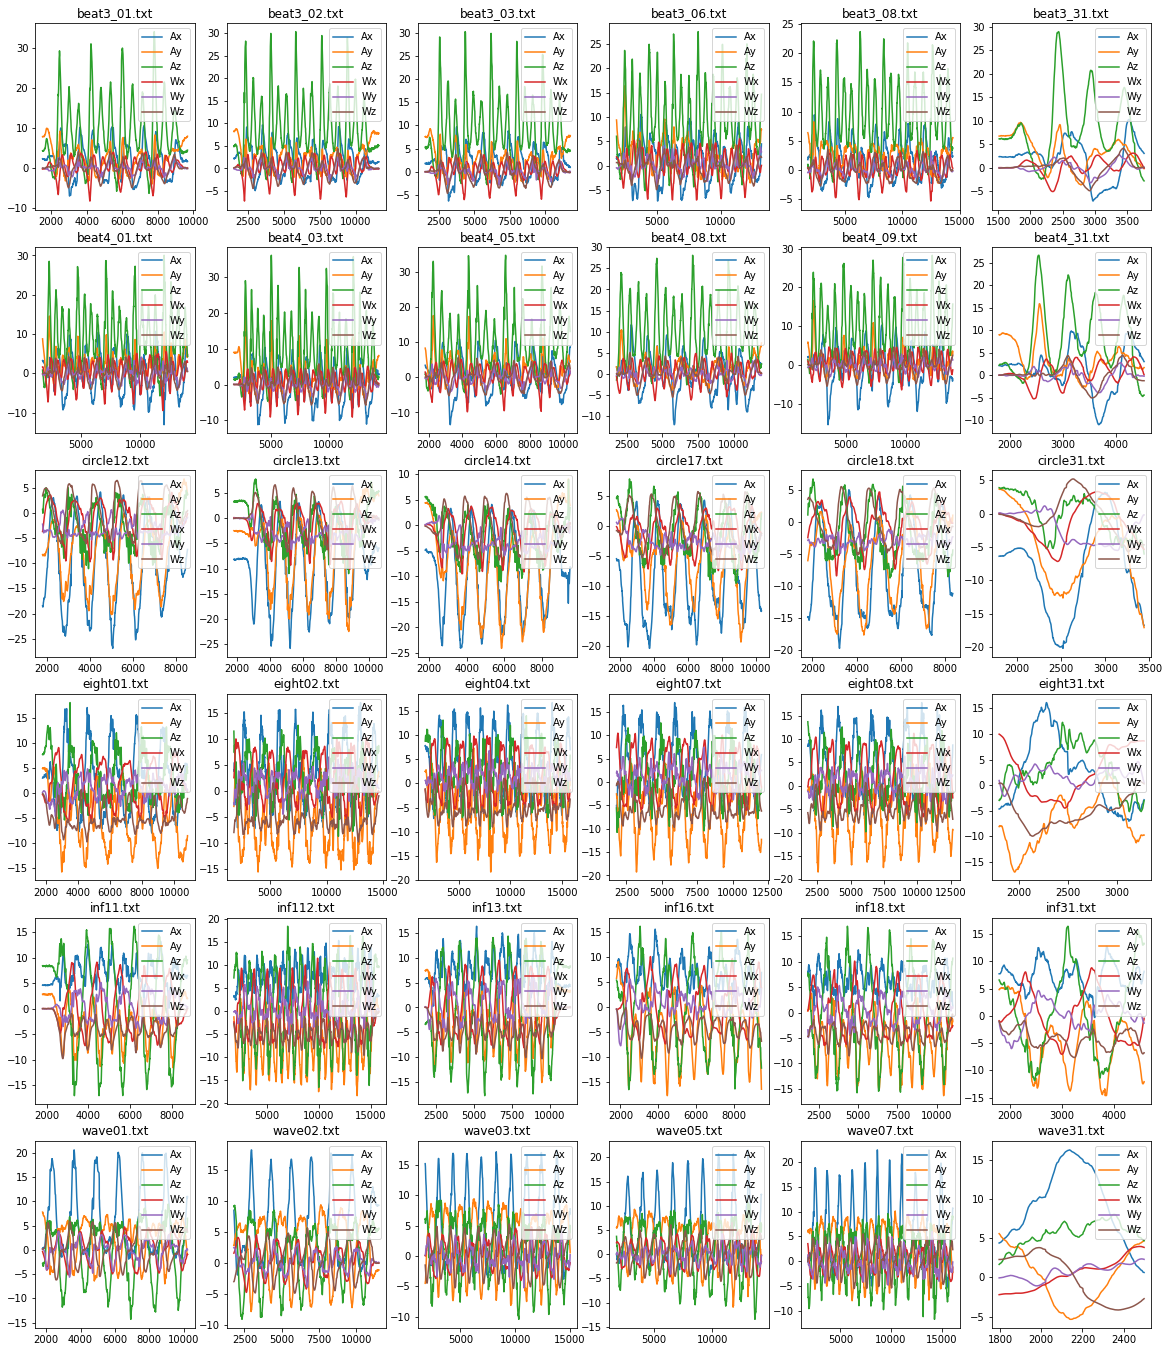

In [95]:
PLT_COL = len(train_X[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X[g]:
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d[:, 0], d[:, 1:])
        plt.legend(["Ax", "Ay", "Az", "Wx", "Wy", "Wz"], loc=1)
        col += 1
    row += 1

### Preprocessing

#### Smoothing data by Savitzky Golay filter

In [96]:
train_X_smoothed = {}
for g in gestures:
    train_X_smoothed[g] = []
    for d in train_X[g]:
        train_X_smoothed[g].append(savgol_filter(d[:, 1:], window_length=5, polyorder=2, deriv=0, delta=1, mode="interp"))
        print(g, train_X_smoothed[g][-1].shape)


beat3 (1620, 6)
beat3 (2008, 6)
beat3 (2043, 6)
beat3 (2265, 6)
beat3 (2495, 6)
beat3 (449, 6)
beat4 (2417, 6)
beat4 (2488, 6)
beat4 (1707, 6)
beat4 (2013, 6)
beat4 (2409, 6)
beat4 (545, 6)
circle (1344, 6)
circle (1754, 6)
circle (1533, 6)
circle (1695, 6)
circle (1301, 6)
circle (328, 6)
eight (1791, 6)
eight (2548, 6)
eight (2771, 6)
eight (2033, 6)
eight (2158, 6)
eight (296, 6)
inf (1383, 6)
inf (2779, 6)
inf (1895, 6)
inf (1525, 6)
inf (1835, 6)
inf (552, 6)
wave (1666, 6)
wave (1926, 6)
wave (2625, 6)
wave (2470, 6)
wave (2843, 6)
wave (141, 6)


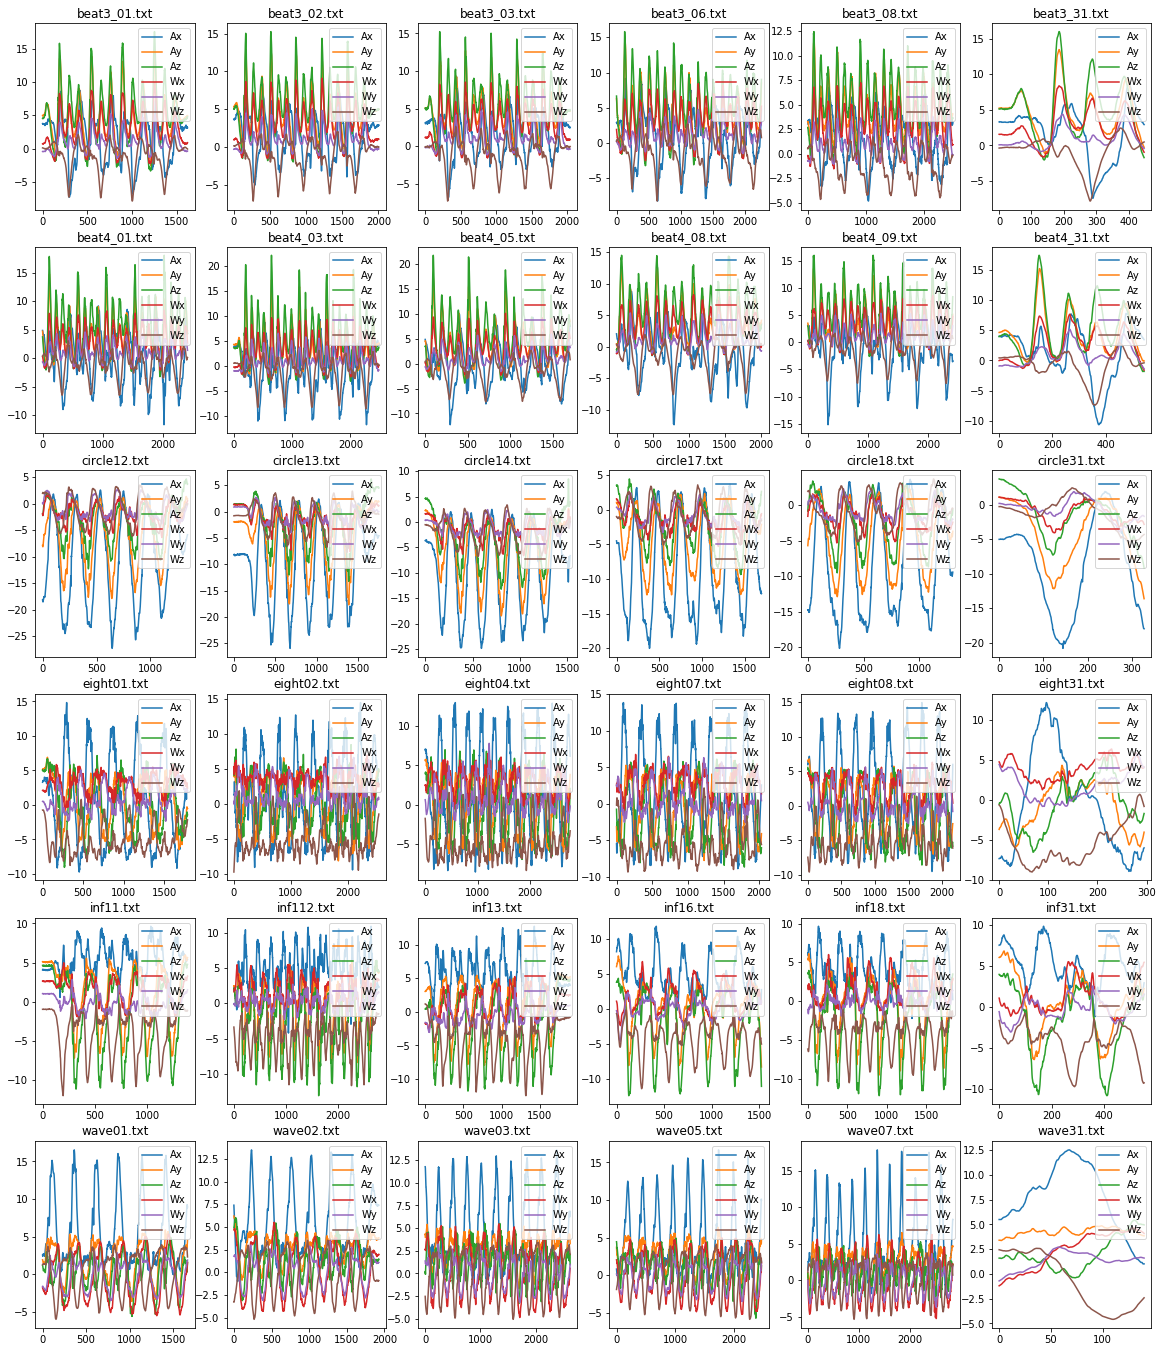

In [97]:
PLT_COL = len(train_X[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X_smoothed[g]:
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d)
        plt.legend(["Ax", "Ay", "Az", "Wx", "Wy", "Wz"], loc=1)
        col += 1
    row += 1

#### Discretize the sequences by K-means

In [98]:
%%time

# use only 6 axises data
X = None
for g in gestures:
    if X is None:
        X = np.concatenate(train_X_smoothed[g])
    else:
        X = np.concatenate([X, np.concatenate(train_X_smoothed[g])])
print(X.shape)

kmeans = KMeans(n_clusters=20, random_state=0).fit(X)
train_X_quantized = {}
for g in gestures:
    train_X_quantized[g] = []
    for d in train_X_smoothed[g]:
        train_X_quantized[g].append(kmeans.predict(d).reshape(-1, 1))
        print(g, train_X_quantized[g][-1].shape)    

(63651, 6)
beat3 (1620, 1)
beat3 (2008, 1)
beat3 (2043, 1)
beat3 (2265, 1)
beat3 (2495, 1)
beat3 (449, 1)
beat4 (2417, 1)
beat4 (2488, 1)
beat4 (1707, 1)
beat4 (2013, 1)
beat4 (2409, 1)
beat4 (545, 1)
circle (1344, 1)
circle (1754, 1)
circle (1533, 1)
circle (1695, 1)
circle (1301, 1)
circle (328, 1)
eight (1791, 1)
eight (2548, 1)
eight (2771, 1)
eight (2033, 1)
eight (2158, 1)
eight (296, 1)
inf (1383, 1)
inf (2779, 1)
inf (1895, 1)
inf (1525, 1)
inf (1835, 1)
inf (552, 1)
wave (1666, 1)
wave (1926, 1)
wave (2625, 1)
wave (2470, 1)
wave (2843, 1)
wave (141, 1)
CPU times: user 17.5 s, sys: 5.64 s, total: 23.1 s
Wall time: 9.9 s


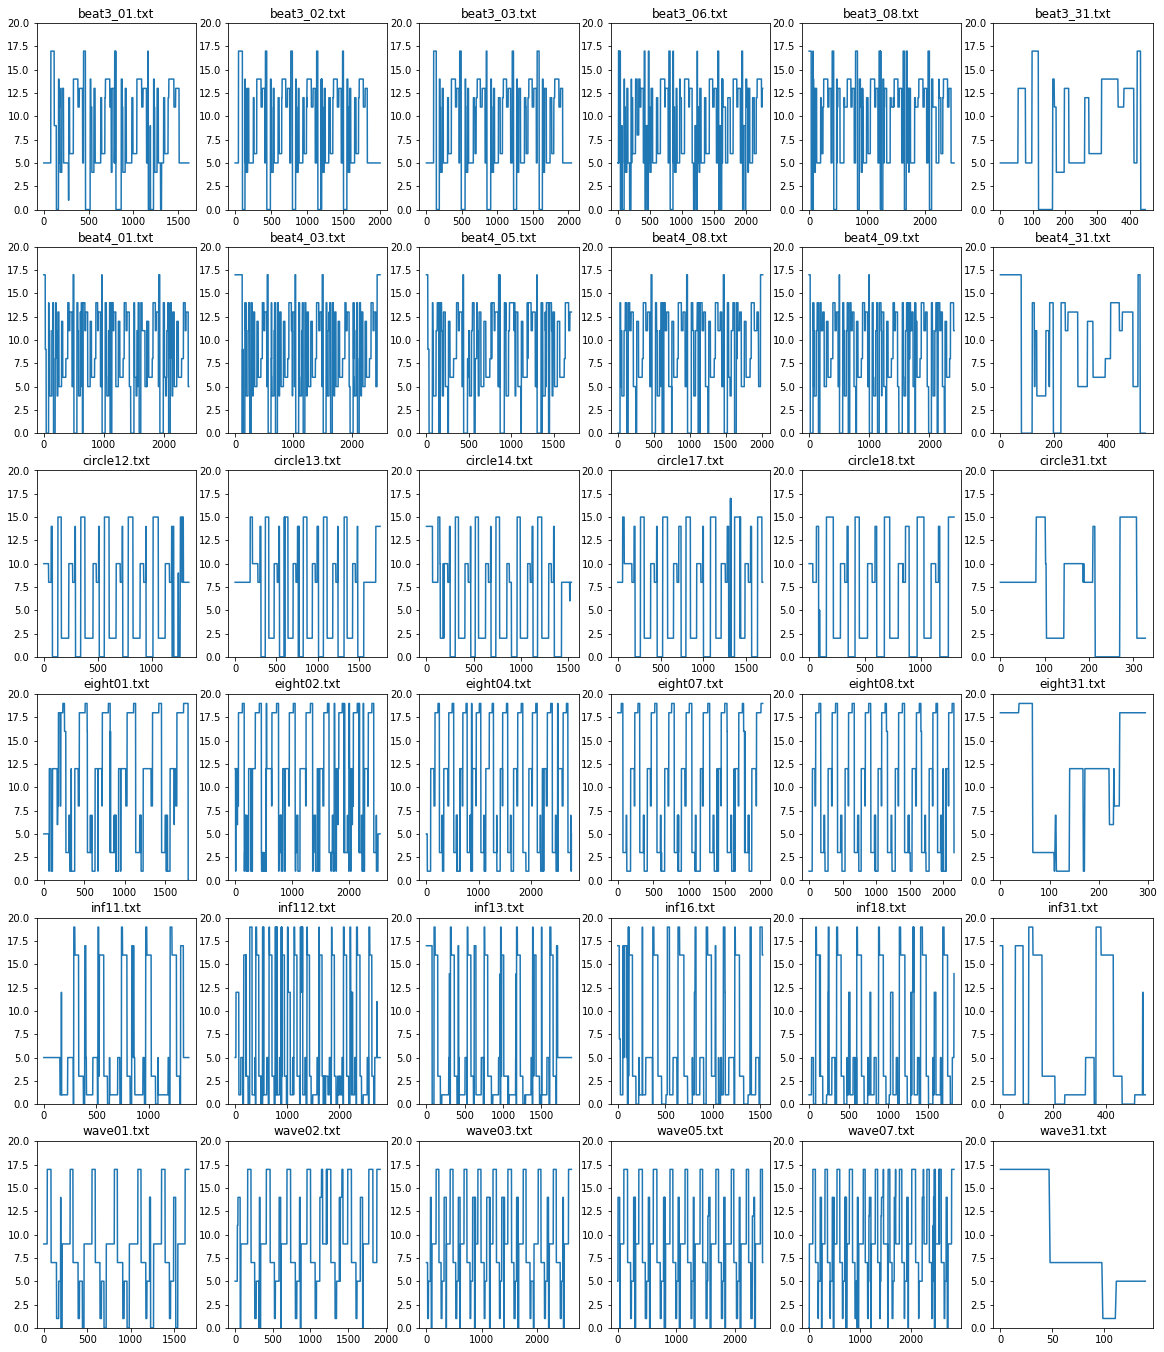

In [99]:
PLT_COL = len(train_X_quantized[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 24])
row, col = 0, 1
for g in gestures:
    col = 1
    for d in train_X_quantized[g]:
        ax = plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(d)
        ax.set_ylim([0, 20])
        col += 1
    row += 1

### Hold out 20% for cross-validation

In [100]:
split_ratio = 0.2

dev_test_indices = {}
x_train_dev = {}
x_test_dev = {}
file_train_dev = {}
file_test_dev = {}

dev_data = train_X_quantized

for g in gestures:
    test_size = int(len(dev_data[g]) * split_ratio)
    dev_test_indices[g] = sorted(random.sample(range(len(dev_data[g])), test_size))
    x_train_dev[g] = np.array([dev_data[g][i] for i in range(len(dev_data[g])) if i not in dev_test_indices[g]])
    x_test_dev[g] = np.array([dev_data[g][i] for i in range(len(dev_data[g])) if i in dev_test_indices[g]])
    file_train_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i not in dev_test_indices[g]])
    file_test_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i in dev_test_indices[g]])

print("Split Ratio:", 0.2)

for g in gestures: 
    print("---------------------------------")
    print(g, "=> test set picked:", dev_test_indices[g])
    print("training set: ", file_train_dev[g])
    print("test set: ", file_test_dev[g])
    

Split Ratio: 0.2
---------------------------------
beat3 => test set picked: [3]
training set:  ['beat3_01.txt' 'beat3_02.txt' 'beat3_03.txt' 'beat3_08.txt'
 'beat3_31.txt']
test set:  ['beat3_06.txt']
---------------------------------
beat4 => test set picked: [4]
training set:  ['beat4_01.txt' 'beat4_03.txt' 'beat4_05.txt' 'beat4_08.txt'
 'beat4_31.txt']
test set:  ['beat4_09.txt']
---------------------------------
circle => test set picked: [2]
training set:  ['circle12.txt' 'circle13.txt' 'circle17.txt' 'circle18.txt'
 'circle31.txt']
test set:  ['circle14.txt']
---------------------------------
eight => test set picked: [1]
training set:  ['eight01.txt' 'eight04.txt' 'eight07.txt' 'eight08.txt' 'eight31.txt']
test set:  ['eight02.txt']
---------------------------------
inf => test set picked: [4]
training set:  ['inf11.txt' 'inf112.txt' 'inf13.txt' 'inf16.txt' 'inf31.txt']
test set:  ['inf18.txt']
---------------------------------
wave => test set picked: [1]
training set:  ['wave

### HMM models for gesture recognition

In [101]:
%%time

dev_models = {}
for g in gestures:
    dev_models[g] = hmm.GaussianHMM(n_components=10, covariance_type="diag")
    dev_models[g].fit(np.concatenate(x_train_dev[g]))

/Users/ctc316/Desktop/Project_2/gesture-recognition/venv/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/ctc316/Desktop/Project_2/gesture-recognition/venv/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


CPU times: user 25.8 s, sys: 5.18 s, total: 31 s
Wall time: 11.2 s


#### Predict

In [72]:
correct = 0
for g in gestures:
    print("--------", g, "---------")
    scores = np.array([dev_models[m_g].score(x_test_dev[g][0]) for m_g in gestures])
    for i in range(len(scores)):
        print("{:6} ->  {}".format(gestures[i], scores[i]))
        
    y_pred = gestures[np.argmax(scores)]
    print("Predict:", y_pred, "\n")
    if y_pred == g:
        correct += 1

print("accuracy: ", float(correct) / len(gestures))

-------- beat3 ---------
beat3  ->  31.762103981212057
beat4  ->  -246.21438788916996
circle ->  -10610.614700123298
eight  ->  -15986.612436975913
inf    ->  -5760.72761379967
wave   ->  -2014.0814088884897
Predict: beat3 

-------- beat4 ---------
beat3  ->  -3.0446391661953713
beat4  ->  683.7648421259661
circle ->  -14514.820870480828
eight  ->  -19395.547308058653
inf    ->  -8849.333773233591
wave   ->  -2818.9352701482935
Predict: beat4 

-------- circle ---------
beat3  ->  -2286.0217338087887
beat4  ->  -4250.994830083062
circle ->  -225.91319941900878
eight  ->  -16455.355247562562
inf    ->  -10323.475031091444
wave   ->  -12620.67207683191
Predict: circle 

-------- eight ---------
beat3  ->  -7713.013113040212
beat4  ->  -34886.83949121322
circle ->  -32298.357515265478
eight  ->  870.7522934723565
inf    ->  -686.4984440050179
wave   ->  -21615.130258696263
Predict: eight 

-------- inf ---------
beat3  ->  -8989.367154922316
beat4  ->  -33060.35009654711
circle ->  -3127

### Final model training and save to local

In [61]:
model_dir = './models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [62]:
dump(kmeans, model_dir + 'kmeans.joblib') 

['./models/kmeans.joblib']

In [63]:
%%time

models = {}
for g in gestures:
    models[g] = hmm.GaussianHMM(n_components=10, covariance_type="diag")
    models[g].fit(np.concatenate(train_X_smoothed[g]))
    dump(models[g], model_dir + g + '.joblib') 

CPU times: user 38.8 s, sys: 7.97 s, total: 46.8 s
Wall time: 15.7 s
